In [1]:
import re
import numpy as np
import pandas as pd
from pandas.core.dtypes.dtypes import CategoricalDtype
from scipy.stats import norm, skew
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

In [3]:
dtype = {'Agencia_ID': 'int16'}
town_state_df = pd.read_csv("town_state.csv", dtype=dtype)

town_state_df['Town_ID'] = town_state_df.Town.apply(lambda x: x.split(' ')[0]).astype('int16')
town_state_df['Town_name'] = town_state_df.Town.apply(lambda x: ' '.join(x.split(' ')[1:]))

print(f'town_state\'s shape: {town_state_df.shape}')
town_state_df.head(5)

town_state's shape: (790, 5)


,Agencia_ID,Town,State,Town_ID,Town_name
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2002,AG. AZCAPOTZALCO
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,2004,AG. CUAUTITLAN
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",2029,AG.IZTAPALAPA 2


In [4]:
town_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Agencia_ID  790 non-null    int16 
 1   Town        790 non-null    object
 2   State       790 non-null    object
 3   Town_ID     790 non-null    int16 
 4   Town_name   790 non-null    object
dtypes: int16(2), object(3)
memory usage: 21.7+ KB


In [5]:
dtype = {'Cliente_ID': 'int32'}
client_df = pd.read_csv("cliente_tabla.csv", dtype=dtype)

dup_sr = client_df.groupby('Cliente_ID')['Cliente_ID'].count().astype('int8')
dup_sr.name = 'dup_num'
client_df = pd.merge(client_df, pd.DataFrame(dup_sr).reset_index())
del dup_sr

print(f'client\'s shape: {client_df.shape}')
client_df.head(5)

client's shape: (935362, 3)


,Cliente_ID,NombreCliente,dup_num
0,0,SIN NOMBRE,1
1,1,OXXO XINANTECATL,1
2,2,SIN NOMBRE,1
3,3,EL MORENO,1
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,2


In [6]:
dtype = {
    'id': 'int32',
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
}
test_df = pd.read_csv("test.csv", nrows=20000, dtype=dtype)

print(f'test\'s shape: {test_df.shape}')
test_df.head()

test's shape: (20000, 7)


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [7]:
dtype = {
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
    'Venta_uni_hoy': 'int16',
    'Venta_hoy': 'float32',
    'Dev_uni_proxima': 'int32',
    'Dev_proxima': 'float32',
    'Demanda_uni_equil': 'int16',
}
train_df = pd.read_csv("train.csv", nrows=100000, dtype=dtype)

print(f'train\'s shape: {train_df.shape}')
train_df.head()

train's shape: (100000, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.140,0,0.000,3
1,3,1110,7,3301,15766,1216,4,33.520,0,0.000,4
2,3,1110,7,3301,15766,1238,4,39.320,0,0.000,4
3,3,1110,7,3301,15766,1240,4,33.520,0,0.000,4
4,3,1110,7,3301,15766,1242,3,22.920,0,0.000,3


In [8]:
dtype = {'Producto_ID': 'int32'}
product_df = pd.read_csv("producto_tabla.csv", dtype=dtype)

product_df['popular_name'] = product_df.NombreProducto.str.extract(r'^(.*?)(\d*\s\d+(kg|Kg|g|G|ml| ml|p|Reb)\s)', expand=False)[0]
product_df['property'] = product_df.NombreProducto.str.extract(r'^.*\d+(kg|Kg|g|G|ml| ml|p|Reb)\s(.*?)\s\d+$', expand=False)[1]
product_df['unit'] = product_df.NombreProducto.str.extract(r'(\d*\s\d+(kg|Kg|g|G|ml| ml))', expand=False)[0]
product_df['pieces'] =  product_df.NombreProducto.str.extract('(\d+(p|Reb)) ', expand=False)[0]

print(f'product\'s shape: {product_df.shape}')
product_df.head(5)

product's shape: (2592, 6)


,Producto_ID,NombreProducto,popular_name,property,unit,pieces
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750g,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480g,6p
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,CU LON,170g,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45g,4p


In [9]:
sale_price_sr = (train_df.Venta_hoy / train_df.Venta_uni_hoy)
return_price_sr = (train_df.Dev_proxima / train_df.Dev_uni_proxima)
product_price_df = pd.DataFrame({'Producto_ID': train_df.Producto_ID, 'sale_price': sale_price_sr, 'return_price': return_price_sr})

del sale_price_sr
del return_price_sr

print(f'product price\'s shape: {product_price_df.shape}')
product_price_df.head(5)

product price's shape: (100000, 3)


,Producto_ID,sale_price,return_price
0,1212,8.380,NaN
1,1216,8.380,NaN
2,1238,9.830,NaN
3,1240,8.380,NaN
4,1242,7.640,NaN


In [10]:
'''KFold for cross validation'''
kf = KFold(n_splits=3, shuffle=True, random_state=2)

'''Define the validation function'''
def rmsle_cv(model, X, y, cv=kf):
    rmsle = np.sqrt(
        -cross_val_score(
            model,
            X, y,
            scoring="neg_mean_squared_log_error",
            cv=cv,
        )
    )
    return(rmsle)

In [11]:
town_state_df['Town'] = town_state_df['Town'].str.upper()
town_state_df['Town_name'] = town_state_df['Town_name'].str.upper()
town_state_df['State'] = town_state_df['State'].str.upper()

In [12]:
town_state_df.groupby(['Town_name'])['Town_ID'].nunique().sort_values(ascending=False)[:6]

Town_name
PINOTEPA       2
LOS MOCHIS     2
ACAPONETA      1
NOGALES_BW     1
NORTE          1
NUEVO IDEAL    1
Name: Town_ID, dtype: int64

In [13]:
town_state_df[(town_state_df['Town_name'].isin(['LOS MOCHIS', 'PINOTEPA']))].sort_values(by='Town_name')

,Agencia_ID,Town,State,Town_ID,Town_name
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2655,LOS MOCHIS
774,25619,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
387,2055,2055 PINOTEPA,PUEBLA,2055,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA


In [14]:
town_state_df.loc[498, 'Town_ID'] = 2561

In [15]:
town_state_df.head(5)

,Agencia_ID,Town,State,Town_ID,Town_name
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2002,AG. AZCAPOTZALCO
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,2004,AG. CUAUTITLAN
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",2029,AG.IZTAPALAPA 2


In [16]:
town_state_df.groupby('Town_ID')['Town'].nunique().sort_values(ascending=False)

Town_ID
2169    2
2152    2
2561    2
2001    1
2391    1
       ..
2257    1
2258    1
2259    1
2260    1
3216    1
Name: Town, Length: 256, dtype: int64

In [17]:
town_state_df[town_state_df.Town_ID.isin([2561, 2169, 2152])].sort_values(by='Town_ID')

,Agencia_ID,Town,State,Town_ID,Town_name
199,1524,2152 CRUCE DE ANDEN NOROESTE,BAJA CALIFORNIA NORTE,2152,CRUCE DE ANDEN NOROESTE
371,2022,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
583,21529,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
311,1694,2169 CRUCE DE ANDÉN SURESTE,PUEBLA,2169,CRUCE DE ANDÉN SURESTE
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2561,LOS MOCHIS


In [18]:
town_state_df['Town_ID'].max()

3216

In [19]:
town_state_df.loc[199, 'Town_ID'] = 3217
town_state_df.loc[311, 'Town_ID'] = 3218

In [20]:
town_state_df['Town_ID'].nunique()

258

In [21]:
sale_prices_df = product_price_df.drop('return_price', axis=1).dropna().rename(columns={'sale_price': 'price'})
return_prices_df = product_price_df.drop('sale_price', axis=1).dropna().rename(columns={'return_price': 'price'})
prices_df = pd.concat([sale_prices_df, return_prices_df])
prices_df = prices_df.groupby('Producto_ID')['price'].median().reset_index()
prices_df.head(5)

,Producto_ID,price
0,72,3.700
1,73,21.320
2,108,6.400
3,141,13.960
4,145,19.750


In [22]:
product_df['in_train'] = 0
product_df['in_test'] = 0
product_df.loc[product_df['Producto_ID'].isin(test_df['Producto_ID'].unique()), 'in_test'] = 1
product_df.loc[product_df['Producto_ID'].isin(train_df['Producto_ID'].unique()), 'in_train'] = 1
product_df = product_df[(product_df['in_test'] == 1) | (product_df['in_train'] == 1)]
product_df[product_df['property'].isnull()]
product_df.loc[117, 'popular_name'] = 'Donas'
product_df.loc[117, 'property'] = 'Prom BIM'
product_df.loc[117, 'unit'] = None
product_df.loc[117, 'pieces'] = '6p'

product_df.loc[190, 'popular_name'] = 'Paletina para Cafe'
product_df.loc[190, 'property'] = 'NES'
product_df.loc[190, 'unit'] = None
product_df.loc[190, 'pieces'] = None

product_df.loc[381, 'popular_name'] = 'Camioncitos Bimbo'
product_df.loc[381, 'property'] = 'BIM'
product_df.loc[381, 'unit'] = None
product_df.loc[381, 'pieces'] = None

product_df.loc[1152, 'popular_name'] = 'Burrito Vaporero FrijolChorizo'
product_df.loc[1152, 'property'] = 'CU LON'
product_df.loc[1152, 'unit'] = '90g'
product_df.loc[1152, 'pieces'] = None

product_df.loc[1677, 'popular_name'] = 'Tarima Twin Pack Thins Multig'
product_df.loc[1677, 'property'] = 'CU ORO'
product_df.loc[1677, 'unit'] = None
product_df.loc[1677, 'pieces'] = None

product_df.loc[1888, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1888, 'property'] = 'Prom MTA LAR'
product_df.loc[1888, 'unit'] = '204g'
product_df.loc[1888, 'pieces'] = None

product_df.loc[1889, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1889, 'property'] = 'Prom LAR'
product_df.loc[1889, 'unit'] = '204g'
product_df.loc[1889, 'pieces'] = None

product_df.loc[2449, 'popular_name'] = 'Galleta Granel Classics Chocolate'
product_df.loc[2449, 'property'] = 'GBI'
product_df.loc[2449, 'unit'] = None
product_df.loc[2449, 'pieces'] = None
product_df[product_df['popular_name'].isnull()]
product_df.loc[877, 'popular_name'] = 'Tortilla Hna Chihuahua'
product_df.loc[877, 'unit'] = '535g'
product_df.loc[877, 'pieces'] = '10p'

product_df.loc[1585, 'popular_name'] = 'Principe Cho Bco MG'
product_df.loc[1585, 'unit'] = '110g'
product_df.loc[1585, 'pieces'] = '10p'

product_df.loc[1748, 'popular_name'] = 'Combo Salma mas Levite'
product_df.loc[1748, 'unit'] = '1360g'
product_df.loc[1748, 'pieces'] = None
product_df['pieces'] = product_df['pieces'].str.extract(r'(\d+)(p|Reb)')[0]
product_df['weight'] = product_df['unit'].str.strip()
product_df['weight'] = product_df['weight'].str.replace(' ', '.')
product_df['weight'] = product_df['weight'].str.upper()
w = product_df['weight'].str.extract('(.+?)(KG|G|ML)', expand=True)
product_df['weight'] = w[0].astype('float') * w[1].map({'KG':1000, 'G':1, 'ML':1})
product_df = pd.merge(product_df, prices_df, how='left')


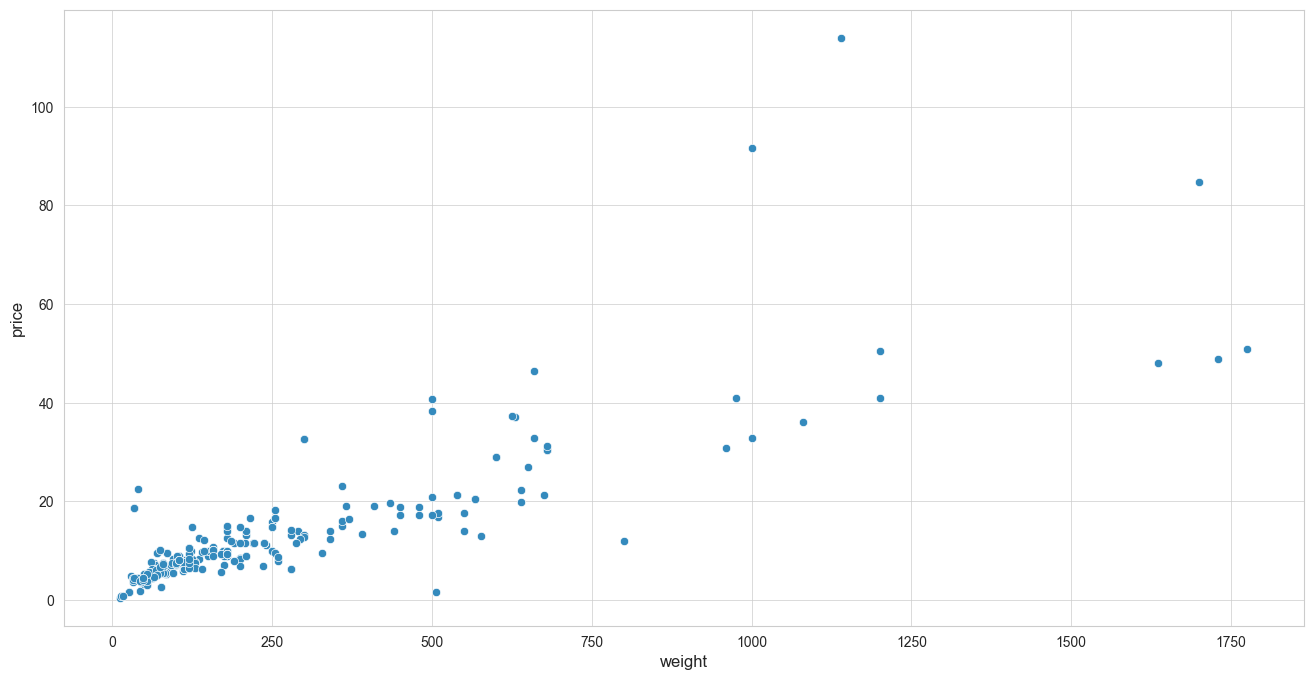

In [57]:
product_df['pieces'] = product_df['pieces'].fillna(1)

product_df[product_df['weight'].isnull()]['price'].max()

product_df[product_df['price'].isnull()]['weight'].max()

df = product_df.dropna()
df = df[(df['price'] <= 311) & (df['weight'] <= 1880)]
plt.figure(figsize=(16,8))
sns.scatterplot(x='weight', y='price', data=df)
del df

In [68]:
from sklearn.linear_model import LinearRegression

df = product_df.dropna()
df = df[(df['price'] <= 100) & (df['weight'] <= 1880)]
print(df['price'].isnull().sum())
print(df['weight'].isnull().sum())

0
0


In [61]:
# predict missing prices
lf = LinearRegression()
lf.fit(df['weight'].values.reshape(-1, 1), df['price'])

prices = lf.predict(product_df[product_df['price'].isnull()]['weight'].values.reshape(-1, 1))

product_df.loc[product_df['price'].isnull(), 'price'] = prices

# predict missing weights
lf = LinearRegression()
lf.fit(df['price'].values.reshape(-1, 1), df['weight'])

weights = lf.predict(product_df[product_df['weight'].isnull()]['price'].values.reshape(-1, 1))

product_df.loc[product_df['weight'].isnull(), 'weight'] = weights

del df
del prices
del weights

(product_df.drop(['unit'], axis=1).isnull().sum() == 0).all()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [24]:
product_df['pieces'] = product_df['pieces'].astype('int16')
product_df['in_train'] = product_df['in_train'].astype('bool')
product_df['in_test'] = product_df['in_test'].astype('bool')
product_df['weight'] = product_df['weight'].astype('float32')
product_df['price'] = product_df['price'].astype('float32')
town_state_df['State'] = town_state_df['State'].astype('category')
train_df['Canal_ID'] = train_df['Canal_ID'].astype('category')
test_df['Canal_ID'] = test_df['Canal_ID'].astype('category')

In [25]:
train_df.drop(['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)

In [26]:
train_df = pd.merge(train_df, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
test_df = pd.merge(test_df, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
train_df.drop('Agencia_ID', axis=1, inplace=True)
test_df.drop('Agencia_ID', axis=1, inplace=True)

In [27]:
train_df = pd.merge(
    train_df,
    product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')
test_df = pd.merge(
    test_df,
    product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')

In [28]:
train_df.head(5)

,Semana,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town_ID,popular_name,property,pieces,weight,price
0,3,7,3301,15766,1212,3,2008,Roles Canela,BIM,2,120.000,8.380
1,3,7,3301,15766,1216,4,2008,Roles Glass,BIM,2,135.000,8.380
2,3,7,3301,15766,1238,4,2008,Panquecito Gota Choc,BIM,2,140.000,9.830
3,3,7,3301,15766,1240,4,2008,Mantecadas Vainilla,BIM,4,125.000,8.380
4,3,7,3301,15766,1242,3,2008,Donitas Espolvoreadas,BIM,6,105.000,7.640


In [29]:
semana_med_s = train_df.groupby('Semana')['Demanda_uni_equil'].median()

semana_med_s

train_df.drop('Semana', axis=1, inplace=True)
test_df.drop('Semana', axis=1, inplace=True)
del semana_med_s

In [30]:
client_med_s = train_df.groupby('Cliente_ID')['Demanda_uni_equil'].median().astype('int16')
client_med_s.name = 'client_med'

In [31]:
popular_name_med_s = train_df.groupby('popular_name')['Demanda_uni_equil'].median().astype('int16')
popular_name_med_s.name = 'popular_name_med'

In [32]:
town_id_med_s = train_df.groupby('Town_ID')['Demanda_uni_equil'].median().astype('int16')
town_id_med_s.name = 'town_id_med'

In [33]:
ruta_id_med_s = train_df.groupby('Ruta_SAK')['Demanda_uni_equil'].median().astype('int16')
ruta_id_med_s.name = 'ruta_id_med'

In [34]:
test_df = pd.merge(test_df, client_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, popular_name_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, town_id_med_s.reset_index(), how='left')
test_df = pd.merge(test_df, ruta_id_med_s.reset_index(), how='left')

train_df = pd.merge(train_df, client_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, popular_name_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, town_id_med_s.reset_index(), how='left')
train_df = pd.merge(train_df, ruta_id_med_s.reset_index(), how='left')

In [35]:
test_df['popular_name_med'] = test_df['popular_name_med'].fillna(test_df['popular_name_med'].mean())
test_df['client_med'] = test_df['client_med'].fillna(test_df['client_med'].mean())
test_df['ruta_id_med'] = test_df['ruta_id_med'].fillna(test_df['ruta_id_med'].mean())

In [36]:
train_df['client_med'] = train_df['client_med'].astype('int16')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('int16')
train_df['town_id_med'] = train_df['town_id_med'].astype('int16')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('int16')
test_df['client_med'] = test_df['client_med'].astype('int16')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('int16')
test_df['town_id_med'] = test_df['town_id_med'].astype('int16')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('int16')

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [37]:
train_df.drop(
    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
    axis=1, inplace=True)
test_df.drop(
    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
    axis=1, inplace=True)

In [38]:
'''Plot histogram of numerical variables to validate pandas intuition.'''
def draw_histograms(df, variables, n_rows, n_cols, size):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        df[var_name].hist(bins=40, ax=ax, color='skyblue', alpha=0.8, figsize=size)
        ax.set_title(var_name, fontsize=43)
        ax.tick_params(axis='both', which='major', labelsize=35)
        ax.tick_params(axis='both', which='minor', labelsize=35)
        ax.set_xlabel('')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [39]:
skewness = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.75].index
skewness[skew_index].sort_values(ascending=False)

client_med          86.799
popular_name_med    80.370
Demanda_uni_equil   50.041
price                8.149
ruta_id_med          3.100
town_id_med          3.093
dtype: float64

In [40]:
skewness = test_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.75].index
skewness[skew_index].sort_values(ascending=False)

client_med         30.527
popular_name_med   13.214
ruta_id_med         1.114
dtype: float64

In [41]:
'''BoxCox Transform'''
lam = 0.01
for column in skew_index:
    train_df[column] = boxcox1p(train_df[column], lam)
    test_df[column] = boxcox1p(test_df[column], lam)

In [42]:
train_df['client_med'] = train_df['client_med'].astype('float32')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('float32')
train_df['town_id_med'] = train_df['town_id_med'].astype('float32')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('float32')

In [43]:
test_df['client_med'] = test_df['client_med'].astype('float32')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('float32')
test_df['town_id_med'] = test_df['town_id_med'].astype('float32')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('float32')

In [44]:
sample_train_df = train_df.sample(n=10000)
sample_train_df['log_target'] = np.log1p(sample_train_df['Demanda_uni_equil'])

In [45]:
sample_train_df.head(5)

,Canal_ID,Demanda_uni_equil,weight,price,client_med,popular_name_med,town_id_med,ruta_id_med,log_target
22023,1,1,410.000,18.980,1.808,1.105,4.000,1.622,0.693
43201,1,2,66.000,6.760,1.396,1.622,4.000,1.622,1.099
91684,1,2,123.000,9.910,0.696,1.396,4.000,1.622,1.099
94341,1,16,55.000,3.020,1.622,2.329,4.000,1.396,2.833
67002,1,5,113.000,6.250,1.808,1.808,4.000,1.622,1.792


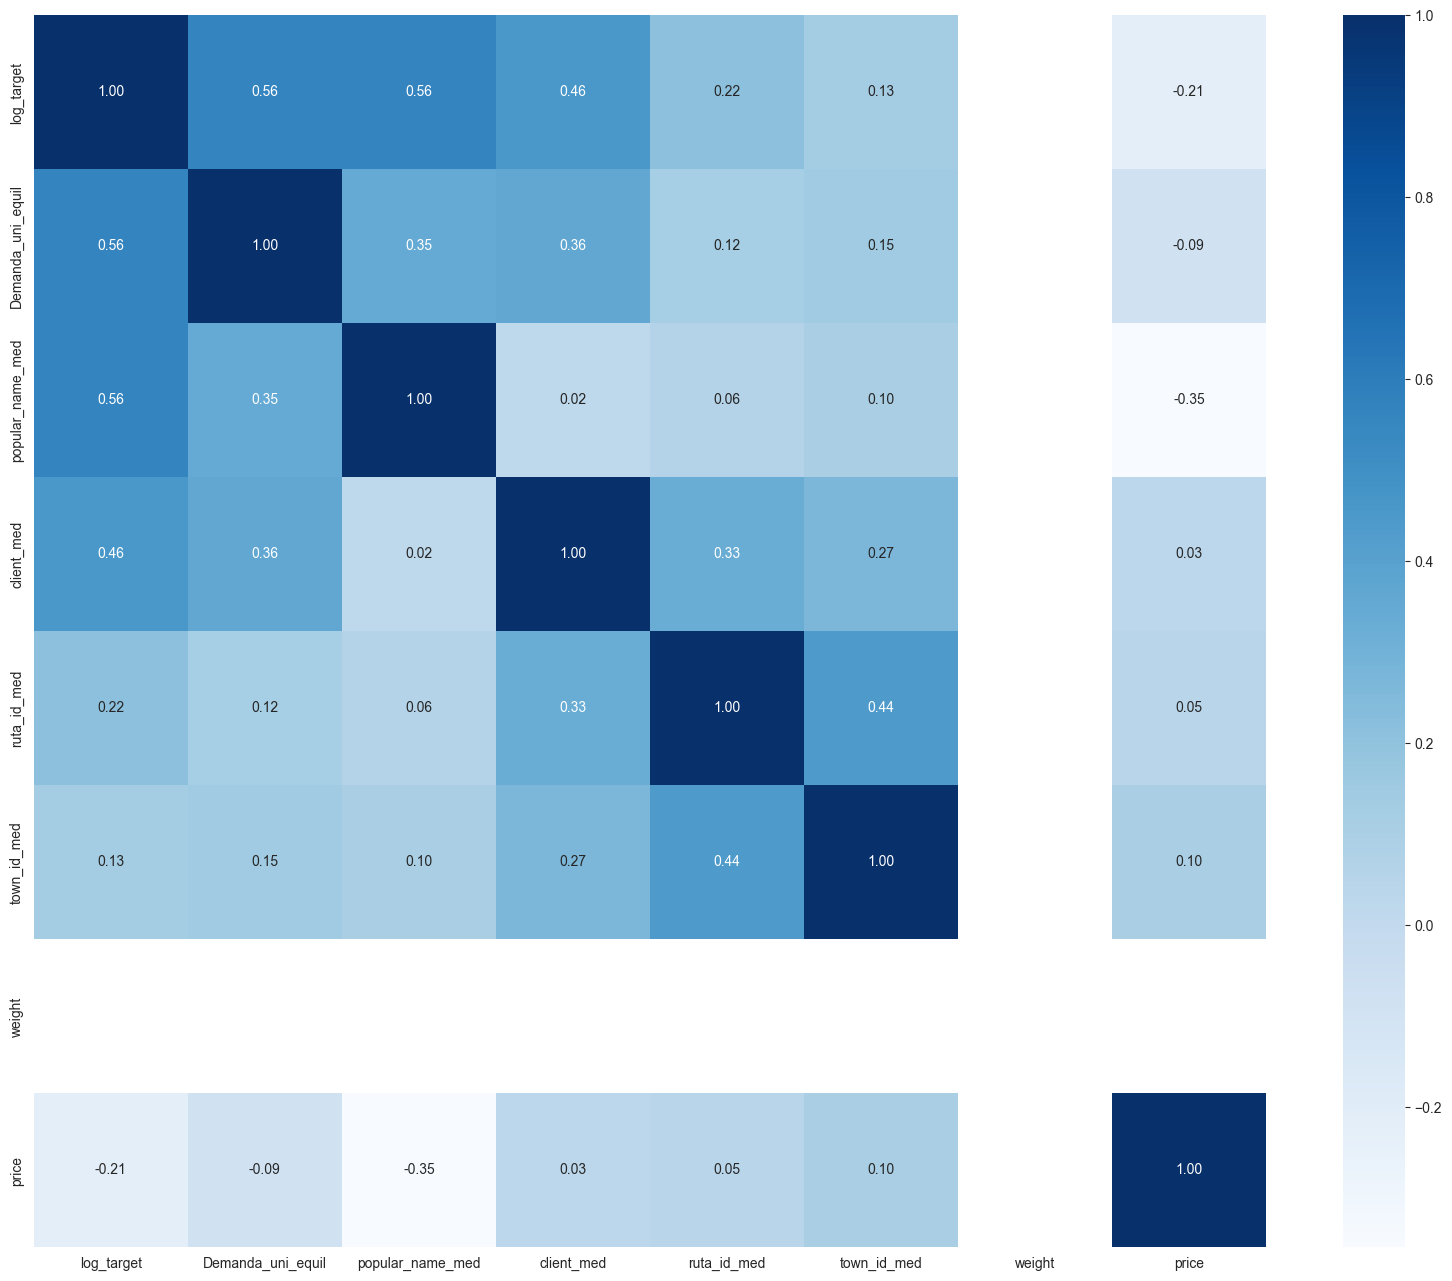

In [46]:
'''correlation matrix'''
plt.subplots(figsize=(20, 16))
k = 20 #number of variables for heatmap
corrmat = sample_train_df.corr()
cols = corrmat.nlargest(k, 'log_target')['log_target'].index

cm = np.corrcoef(sample_train_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, cmap='Blues',
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [47]:
'''Check feature inportance by applying LightGBM'''
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(num_leaves=1000,
                              max_depth=5,
                              learning_rate=0.1,
                              random_state=2)
model_lgb.fit(sample_train_df.drop(['Demanda_uni_equil', 'log_target'], axis=1).head(100), sample_train_df['log_target'].head(100))

LGBMRegressor(max_depth=5, num_leaves=1000, random_state=2)

In [48]:
df = pd.DataFrame(model_lgb.feature_importances_,
             index=sample_train_df.drop(['Demanda_uni_equil', 'log_target'], axis=1).columns,
             columns=['importance']).sort_values('importance', ascending=False)
df[df.importance > 10]

,importance
weight,85
popular_name_med,75
price,69
client_med,37
ruta_id_med,27


In [49]:
'''Importing Modeling Interested Modules'''
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor

In [50]:
'''Adjust dataframe for modeling'''
train_y = train_df['Demanda_uni_equil']
train_df.drop(['Demanda_uni_equil'], axis=1, inplace=True)
train_X = train_df
test_X = test_df.drop('id', axis=1)

'''Transform categorical features to dummy variables'''
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

sample_train_df['Demanda_uni_equil'] = np.expm1(sample_train_df['log_target']).astype('int32')

sample_train_df.head(5)

'''Prepare sample train for the fast training'''
sample_train_y = sample_train_df['Demanda_uni_equil']
sample_train_df.drop(['Demanda_uni_equil'], axis=1, inplace=True)
sample_train_X = sample_train_df

sample_train_X = pd.get_dummies(sample_train_X)

In [51]:
def get_best_params_for_model(model, space_params, evals=333):
    def get_model_score(params):
        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = np.abs(clf.predict(X_test))
        return mean_squared_log_error(y_test, y_pred, squared=False)

    best = fmin(fn=get_model_score, space=space_params, algo=tpe.suggest, max_evals=evals)
    return space_eval(space_params, best)

In [52]:
from sklearn.model_selection import train_test_split
y = sample_train_y
X = sample_train_X
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state= 2)

In [53]:
import hyperopt.hp as hp
from hyperopt import fmin,tpe,space_eval
from sklearn.metrics import mean_squared_log_error
xgboost_params = {
    'max_depth': hp.choice('max_depth', np.arange(1,21,1)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1,10,1)),
    'gamma': hp.choice('gamma', np.arange(0,1,000.1)),
    'reg_alpha': hp.choice('reg_alpha',[1e-5,1e-2,0.1,1]),
    'learning_rate': hp.choice('learning_rate', np.arange(0,1,0.1)),
    'n_estimators': hp.choice('n_estimators', np.arange(50,1000,10)),
    'booster': 'gbtree',
    'n_jobs': 8
}

In [54]:
import xgboost
best_xgboost_params = get_best_params_for_model(xgboost.XGBRegressor, xgboost_params, 150)

100%|████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:13<00:00,  2.09s/trial, best loss: 0.028860525930787178]


In [55]:
best_xgboost_params

{'booster': 'gbtree',
 'gamma': 0.30000000000000004,
 'learning_rate': 0.30000000000000004,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 150,
 'n_jobs': 8,
 'reg_alpha': 1e-05}

In [56]:
forest_test = {
    'max_depth': hp.choice('max_depth', np.arange(1,21,1)),
    'n_estimators': hp.choice('n_estimators', np.arange(50,1000,10)),
    'max_features': hp.choice('max_features', ["sqrt", "log2", None]),
    'n_jobs': 8
}

from sklearn.ensemble import RandomForestRegressor
best_forest_params = get_best_params_for_model(RandomForestRegressor, forest_test, 150)

  0%|                                                                                                                  | 0/150 [00:00<?, ?trial/s, best loss=?]

job exception: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values



  0%|                                                                                                                  | 0/150 [00:00<?, ?trial/s, best loss=?]


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [65]:
best_forest_params

{'max_depth': 12, 'max_features': None, 'n_estimators': 300, 'n_jobs': 10}

In [66]:
compare_params_for_model(RandomForestRegressor, best_forest_params)

Default:0.0016230580445620651, Best: 0.001588023979112057
Difference:3.503406545000802e-05


In [75]:
best_xgboost_params_1 = get_best_params_for_model(xgboost.XGBRegressor, xgboost_params, 300)
compare_params_for_model(xgboost.XGBRegressor, best_xgboost_params_1)

100%|████| 300/300 [20:46<00:00,  4.15s/trial, best loss: 0.0024484706975677548]
Default:0.006224433406873176, Best: 0.0024484706975677548
Difference:0.0037759627093054216


In [77]:
best_xgboost_params_1

{'booster': 'gbtree',
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 2,
 'n_estimators': 160,
 'n_jobs': 8,
 'reg_alpha': 0.1}